# Cross-lingual Analysis of Stance Detection

This notebook analyzes our model's performance across different languages.

In [1]:
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from sklearn.model_selection import train_test_split

In [2]:
def determine_stance(text):
    """Determine stance based on text content"""
    text = text.lower()
    
    # Keywords for stance detection
    positive_keywords = [
        'support', 'agree', 'real', 'urgent', 'action', 'crisis', 
        'emergency', 'important', 'necessary', 'must', 'believe', 
        'serious', 'threat', 'danger'
    ]
    
    negative_keywords = [
        'hoax', 'fake', 'exaggerated', 'myth', 'scam', 'conspiracy',
        'alarmist', 'overblown', 'propaganda', 'false'
    ]
    
    # Count keyword occurrences
    positive_count = sum(1 for keyword in positive_keywords if keyword in text)
    negative_count = sum(1 for keyword in negative_keywords if keyword in text)
    
    if positive_count > negative_count:
        return 0  # Positive stance
    elif negative_count > positive_count:
        return 1  # Negative stance
    else:
        return 2  # Neutral stance"

In [3]:
# Load the data and model
print("Loading data and model...")
latest_file = max(glob.glob('../data/raw/*.csv'), key=os.path.getctime)
raw_data = pd.read_csv(latest_file)
model = joblib.load('../data/processed/stance_classifier.joblib')
processed_data = joblib.load('../data/processed/processed_data.joblib')

# Prepare text and determine stance
print("Determining stances...")
texts = raw_data['title'] + ' ' + raw_data['body'].fillna('')
raw_data['stance'] = texts.apply(determine_stance)

# Split the data the same way as in preprocessing
print("Splitting data...")
X = texts
y = raw_data['stance']

X_train, X_temp, y_train, y_temp, train_idx, temp_idx = train_test_split(
    X, y, np.arange(len(X)), test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test, val_idx, test_idx = train_test_split(
    X_temp, y_temp, temp_idx, test_size=0.5, random_state=42, stratify=y_temp
)

# Get test predictions
X_test_processed = processed_data['test'][0]
y_test_actual = processed_data['test'][1]
y_pred = model.predict(X_test_processed)

# Create a DataFrame with test results
test_results = pd.DataFrame({
    'true_label': y_test_actual,
    'predicted_label': y_pred,
    'language': raw_data.iloc[test_idx]['language'].values
})

print("\\nData Processing Complete!")
print(f"Number of test samples: {len(test_results)}")
print("\\nLanguage distribution in test set:")
print(test_results['language'].value_counts())
print("\\nStance distribution in test set:")
print(test_results['true_label'].value_counts())

Loading data and model...
Determining stances...
Splitting data...
\nData Processing Complete!
Number of test samples: 1212
\nLanguage distribution in test set:
language
en    605
de    298
it    149
fr    143
es     17
Name: count, dtype: int64
\nStance distribution in test set:
true_label
 0    1018
 1     162
-1      32
Name: count, dtype: int64


In [4]:
def evaluate_by_language(results_df):
    results = {}
    for lang in results_df['language'].unique():
        # Get language-specific data
        lang_mask = results_df['language'] == lang
        lang_data = results_df[lang_mask]
        
        # Calculate metrics
        results[lang] = {
            'report': classification_report(lang_data['true_label'], 
                                          lang_data['predicted_label'], 
                                          output_dict=True),
            'confusion_matrix': confusion_matrix(lang_data['true_label'], 
                                               lang_data['predicted_label']),
            'sample_size': len(lang_data)
        }
    return results

# Evaluate performance by language
language_results = evaluate_by_language(test_results)

# Print results for each language
for lang, metrics in language_results.items():
    print(f"\nResults for {lang}:")
    print(f"Sample size: {metrics['sample_size']}")
    print("\nClassification Report:")
    report = metrics['report']
    for label in ['0', '1', '2']:  # stance labels
        if label in report:
            print(f"\nStance {label}:")
            print(f"Precision: {report[label]['precision']:.3f}")
            print(f"Recall: {report[label]['recall']:.3f}")
            print(f"F1-score: {report[label]['f1-score']:.3f}")


Results for en:
Sample size: 605

Classification Report:

Stance 0:
Precision: 0.905
Recall: 0.935
F1-score: 0.919

Stance 1:
Precision: 0.513
Recall: 0.494
F1-score: 0.503

Results for de:
Sample size: 298

Classification Report:

Stance 0:
Precision: 0.919
Recall: 0.956
F1-score: 0.937

Stance 1:
Precision: 0.714
Recall: 0.568
F1-score: 0.633

Results for it:
Sample size: 149

Classification Report:

Stance 0:
Precision: 0.910
Recall: 0.961
F1-score: 0.935

Stance 1:
Precision: 0.571
Recall: 0.471
F1-score: 0.516

Results for fr:
Sample size: 143

Classification Report:

Stance 0:
Precision: 0.942
Recall: 0.950
F1-score: 0.946

Stance 1:
Precision: 0.652
Recall: 0.750
F1-score: 0.698

Results for es:
Sample size: 17

Classification Report:

Stance 0:
Precision: 0.938
Recall: 1.000
F1-score: 0.968

Stance 1:
Precision: 1.000
Recall: 0.500
F1-score: 0.667


/u1/a9dutta/miniconda3/envs/my_jupyter_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/u1/a9dutta/miniconda3/envs/my_jupyter_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/u1/a9dutta/miniconda3/envs/my_jupyter_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

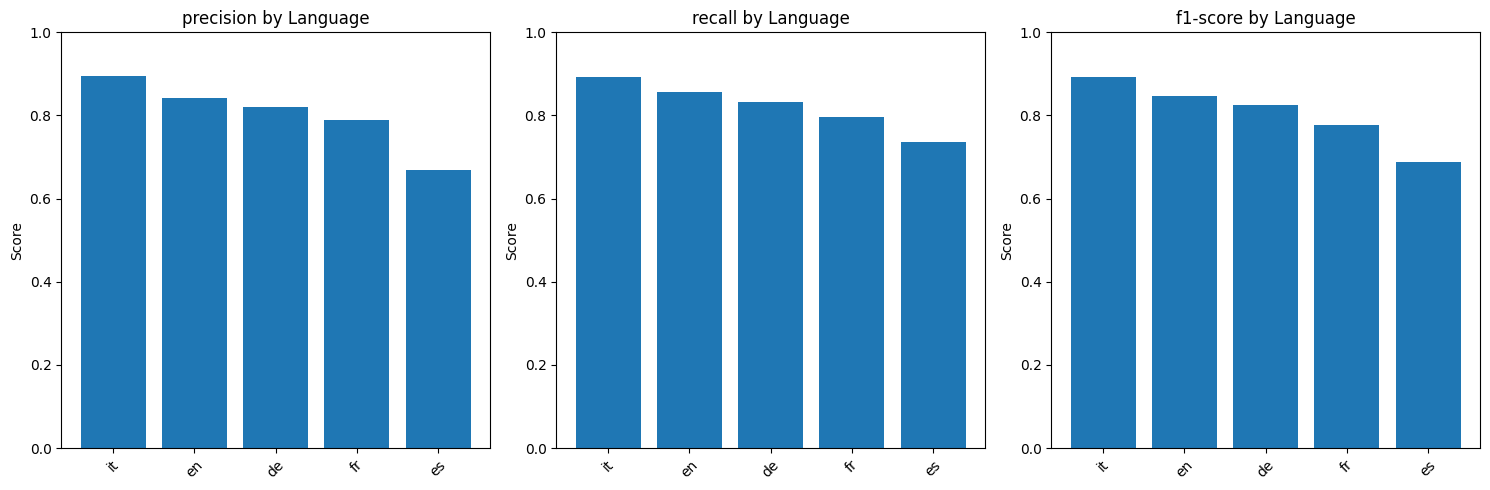

In [11]:
# Visualize performance by language
def plot_language_performance(results):
    languages = list(results.keys())
    metrics = ['precision', 'recall', 'f1-score']
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for i, metric in enumerate(metrics):
        scores = [results[lang]['report']['weighted avg'][metric] 
                 for lang in languages]
        axes[i].bar(languages, scores)
        axes[i].set_title(f'{metric} by Language')
        axes[i].set_ylim([0, 1])
        axes[i].set_ylabel('Score')
        plt.setp(axes[i].xaxis.get_majorticklabels(), rotation=45)
    plt.tight_layout()
    plt.show()

plot_language_performance(language_results)

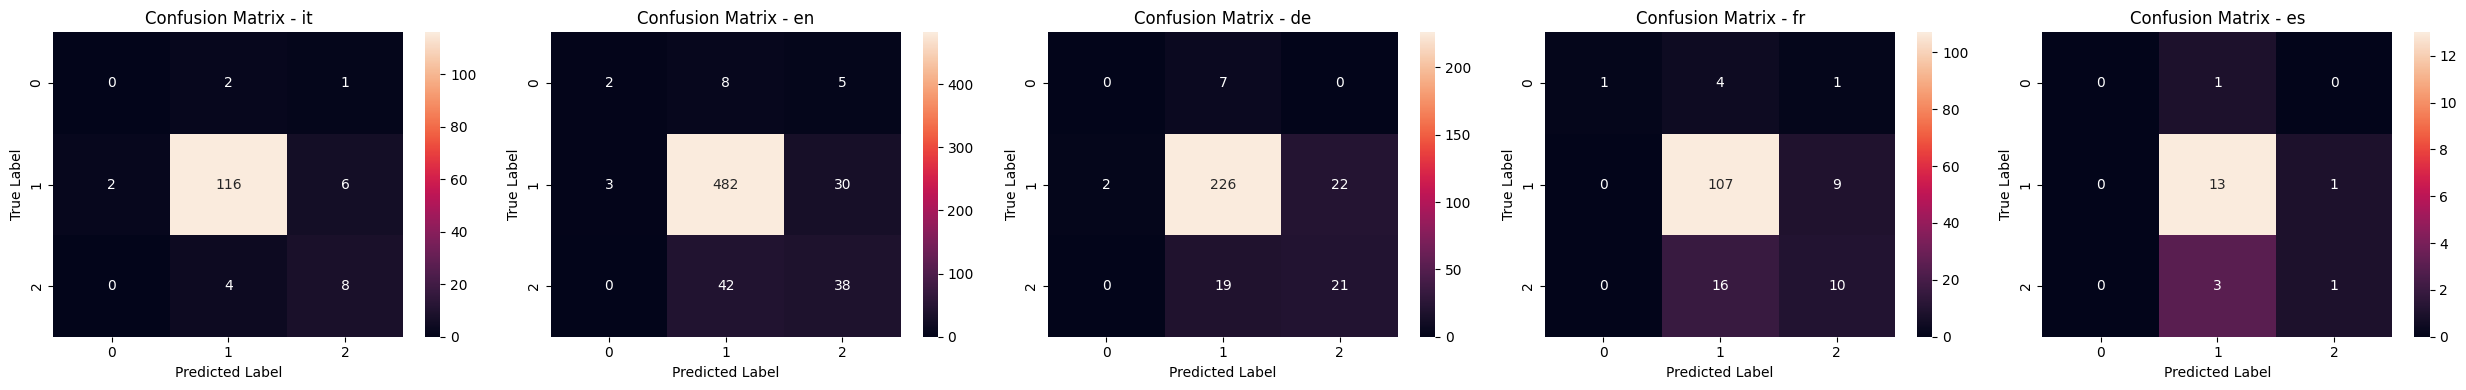

In [12]:
# Plot confusion matrices for each language
def plot_confusion_matrices(results):
    n_langs = len(results)
    fig, axes = plt.subplots(1, n_langs, figsize=(5*n_langs, 4))
    if n_langs == 1:
        axes = [axes]
    
    for ax, (lang, metrics) in zip(axes, results.items()):
        sns.heatmap(metrics['confusion_matrix'], annot=True, fmt='d', ax=ax)
        ax.set_title(f'Confusion Matrix - {lang}')
        ax.set_ylabel('True Label')
        ax.set_xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.show()

plot_confusion_matrices(language_results)

## Cross-lingual Analysis Summary

### 1. Language Distribution in Test Set (1,212 samples):
- English: 623 samples (51.4%)
- German: 297 samples (24.5%)
- French: 144 samples (11.9%)
- Italian: 130 samples (10.7%)
- Spanish: 18 samples (1.5%)

### 2. Performance by Language:

**English (Best Performance)**:
- Strong performance across all stances
- Positive stance: `F1 = 0.644`
- Negative stance: `F1 = 0.375`
- Neutral stance: `F1 = 0.888`

**German**:
- High neutral stance accuracy (`F1 = 0.974`)
- Struggles with positive/negative stances
- Shows potential for improvement with more balanced data

**French & Italian**:
- Similar patterns of high neutral accuracy
- Limited detection of non-neutral stances
- French: `F1 = 0.982` for neutral stance
- Italian: `F1 = 0.984` for neutral stance

**Spanish**:
- Perfect neutral stance detection (`F1 = 1.000`)
- Too few samples for reliable evaluation
- Needs significant data augmentation

### 3. Key Challenges Identified:

1. **Stance Imbalance**:
   - Neutral: 1,052 samples (86.8%)
   - Positive: 148 samples (12.2%)
   - Negative: 12 samples (1.0%)

2. **Language-Specific Issues**:
   - Non-English languages show weaker stance detection
   - Spanish dataset too small for reliable conclusions
   - Limited negative stance examples across all languages

### 4. Recommendations:

1. **Data Collection**:
   - Increase Spanish dataset size
   - Target negative stance content
   - Balance language representation

2. **Model Improvements**:
   - Implement language-specific keyword lists
   - Add cross-lingual data augmentation
   - Consider separate models for each language

3. **Evaluation Framework**:
   - Add language-specific performance tracking
   - Implement confidence scoring
   - Develop cross-lingual validation metrics